## Learned Reconstruction

This notebook demonstrates how to use ODL to perform learned reconstruction of the famous MNIST dataset.

We demonstrate three ways of doing this

* Fully learned reconstruction
* Learned post-processing
* Learned iterative reconstruction

and we also compare to classical reconstruction methods:

* FBP-based reconstruction
* TV-regularized reconstruction

the results should be approximately

| Method                 |   Error  |
|:-----------------------|:--------:|
| FBP                    | 0.152    |
| Fully learned          | 0.025    |
| FBP + learned denoiser | 0.015    |
| Learned Iterative      | 0.011    |
| TV                     | 0.024    |

Note that the examples in this notebook may take some time to run, approximately 10 minutes each can be expected on a reasonable laptop.

# Import dependencies

This should run without errors if all dependencies are installed properly.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import odl
import odl.contrib.tensorflow
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import display, clear_output

In [2]:
# Start a tensorflow session
session = tf.InteractiveSession()

# Set the random seed to enable reproducible code
np.random.seed(0)

# Create operators using ODL

Here we create the needed operators in ODL as usual, we then convert them to tensorflow-compatible functions using the `odl.contrib.tensorflow.as_tensorflow_layer` function.

In [3]:
# Create ODL data structures
space = odl.uniform_discr([-14, -14], [14, 14], [28, 28],
                          dtype='float32')

geometry = odl.tomo.parallel_beam_geometry(space, num_angles=5)
operator = odl.tomo.RayTransform(space, geometry)
fbp_op = odl.tomo.fbp_op(operator)

# Create tensorflow wrappers
tf_op = odl.contrib.tensorflow.as_tensorflow_layer(operator)
tf_op_adj = odl.contrib.tensorflow.as_tensorflow_layer(operator.adjoint)
tf_fbp_op = odl.contrib.tensorflow.as_tensorflow_layer(fbp_op, name="FBP")

# Get data and utilities

We now need to get the data we will use, which in this case is the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, a set of digits 70000 hand-written digits, of which 60000 are used for training and 10000 for testing.

In addition to this, we create a utility `generate_data` which generates sinograms for each digit, as well as a function `evaluate(...)` that we will use to evaluate how good a reconstruction is and `visualize(...)` which shows an example reconstruction.

In [4]:
# Get MNIST data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [5]:
def generate_data(images):
    """Generate data from images
    
    Parameters
    ----------
    images : np.array of shape [Batch, 28, 28, 1]
        The images (in reconstruction space) which we should create data for.
        
    Returns
    -------
    sinograms : np.array of shape [Batch, 5, 41, 1]
        Noisy sinograms corresponding to ``images``
    """
    data = [operator(image.squeeze()).asarray() +
            np.random.randn(*operator.range.shape) for image in images]
    return np.array(data)[..., None]

In [6]:
# Read the first 1000 mnist test points
batch = mnist.test.next_batch(100)
test_images = batch[0].reshape([-1, 28, 28, 1])

# Create test data (persistent to save time)
test_images = test_images
test_data = generate_data(test_images)

def evaluate(result_tensor, data_placeholder):
    """Evaluate a reconstruction method.

    Parameters
    ----------
    result_tensor : `tf.Tensor`, shape (None, 28, 28, 1)
        The tensorflow tensor containing the result of the reonstruction
        operator.
    data_placeholder : `tf.Tensor`, shape (None, 5, 41, 1)
        The tensorflow tensor containing the input to the reconstruction
        operator.

    Returns
    -------
    MSE : float
        Mean squared error of the reconstruction.
    """
    result = result_tensor.eval(
        feed_dict={data_placeholder: test_data})

    return np.mean((result - test_images) ** 2)

In [7]:
def display_progress(i, max_iter, result_tensor, data_placeholder, every=200):
    """Utility function to display training progress."""
    if (i + 1) % every == 0:
        error = evaluate(result_tensor, data_placeholder)
        clear_output()
        display('{}/{} Error: {:.5f}'.format(i + 1, max_iter, error))

In [8]:
def get_tensor_name(tensor, default_name="Truth"):
    """Utility function to get the name of a tensor."""
    try:
        name = tensor.name.split('/')[0]
    except AttributeError:
        name = default_name
    return name

In [33]:
default_indices = np.arange(20)
def visualize(result_tensors, data_placeholder, indices=default_indices):
    """Visualize the result of a reconstruction.
    
    Parameters
    ----------
    result_tensors : list of `tf.Tensor`, shape (None, 28, 28, 1)
        The tensorflow tensor containing the result of the reconstruction
        operator.
    data_placeholder : `tf.Tensor`, shape (None, 5, 41, 1)
        The tensorflow tensor containing the input to the reconstruction
        operator.
    """        
    results = [result_tensor.eval(
        feed_dict={data_placeholder: test_data[indices]}) for result_tensor in result_tensors]
    
    results_ = [test_images[indices]] + results
    names = [get_tensor_name(tensor) for tensor in [None]+result_tensors]
    
    figsize = 2
    fig, rows = plt.subplots(len(indices), len(results_), sharex=True, sharey=True, figsize=(len(results_)*figsize, figsize*len(indices)))
    # stupid matplotlib:
    if len(indices) == 1:
        rows = [rows]
    for i, row in enumerate(rows):
        for name, res, ax in zip(names, results_, row):
            if i == 0:
                ax.set_title(name)
            ax.imshow(res[i].squeeze(), clim=[0,1], cmap="bone")
            ax.set_axis_off()
    plt.show()

Create placeholders. Placeholders are needed in tensorflow since tensorflow is a lazy language,
and hence we first define the computational graph with placeholders as input, and later we evaluate it.


In [10]:
with tf.name_scope('placeholders'):
    x_true = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name="x_true")
    y = tf.placeholder(tf.float32, shape=[None, *operator.range.shape, 1], name="y")

Use the evaluator on the FBP reconstruction as a baseline

FBP Mean squared error: 0.15258172154426575


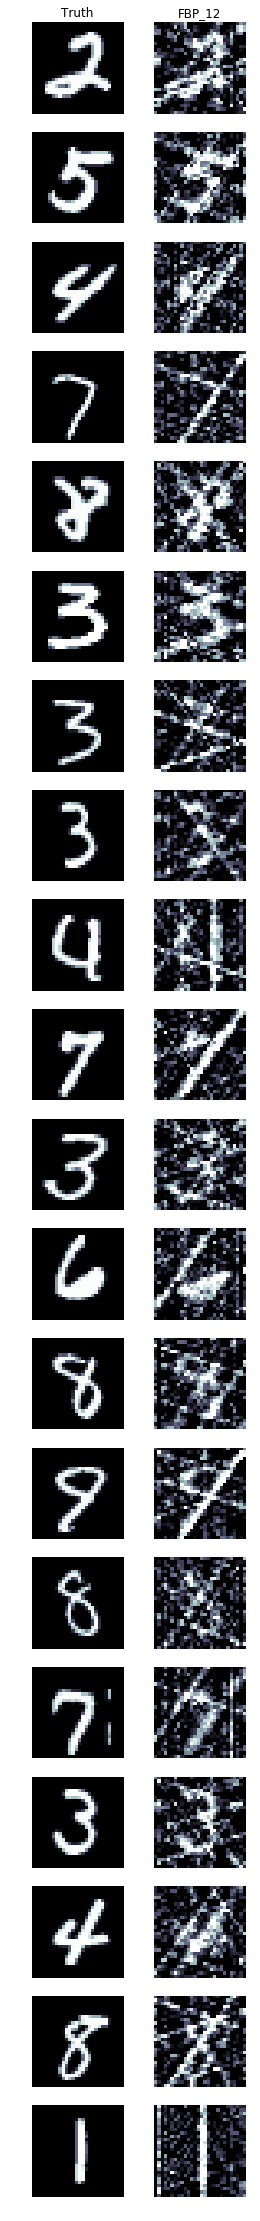

In [34]:
print('FBP Mean squared error: {}'.format(evaluate(tf_fbp_op(y), y)))
visualize([tf_fbp_op(y)], y)

# Fully Learned Reconstruction

The most straight-forward example of a learned reconstruction method is the fully-learned reconstruction. In this method, we use a fully-connected neural network to map data to reconstruction, using no information about the forward operator.

In this example, we use a network of the form

$$
\mathcal{T}_\theta^\dagger(y) = \Lambda_{\theta}(y)
$$

where $\Lambda_{\theta}$ is a MLP with two hidden layers.

In [12]:
with tf.variable_scope('flr', reuse=tf.AUTO_REUSE):  # use a variable scope to allow us to re-tune parameters
    with tf.name_scope('fully_learned_reconstruction'):
        x = tf.contrib.layers.flatten(y)

        x = tf.contrib.layers.fully_connected(x, num_outputs=1024)
        x = tf.contrib.layers.fully_connected(x, num_outputs=1024)
        x = tf.contrib.layers.fully_connected(x, num_outputs=28 * 28,
                                              activation_fn=None)

        x_result_fully = tf.reshape(x, [-1, 28, 28, 1])

    with tf.name_scope('optimizer_fully'):
        loss = tf.reduce_mean((x_result_fully - x_true) ** 2)
        optimizer = tf.train.AdamOptimizer().minimize(loss)
        
# Initialize current variables
session.run([v.initializer for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='flr')]);

In [13]:
max_iter = 10000
for i in range(max_iter):
    batch = mnist.train.next_batch(5)
    images = batch[0].reshape([-1, 28, 28, 1])
    data = generate_data(images)

    session.run(optimizer, feed_dict={x_true: images, y: data})
    
    display_progress(i, max_iter, x_result_fully, y)

'10000/10000 Error: 0.02416'

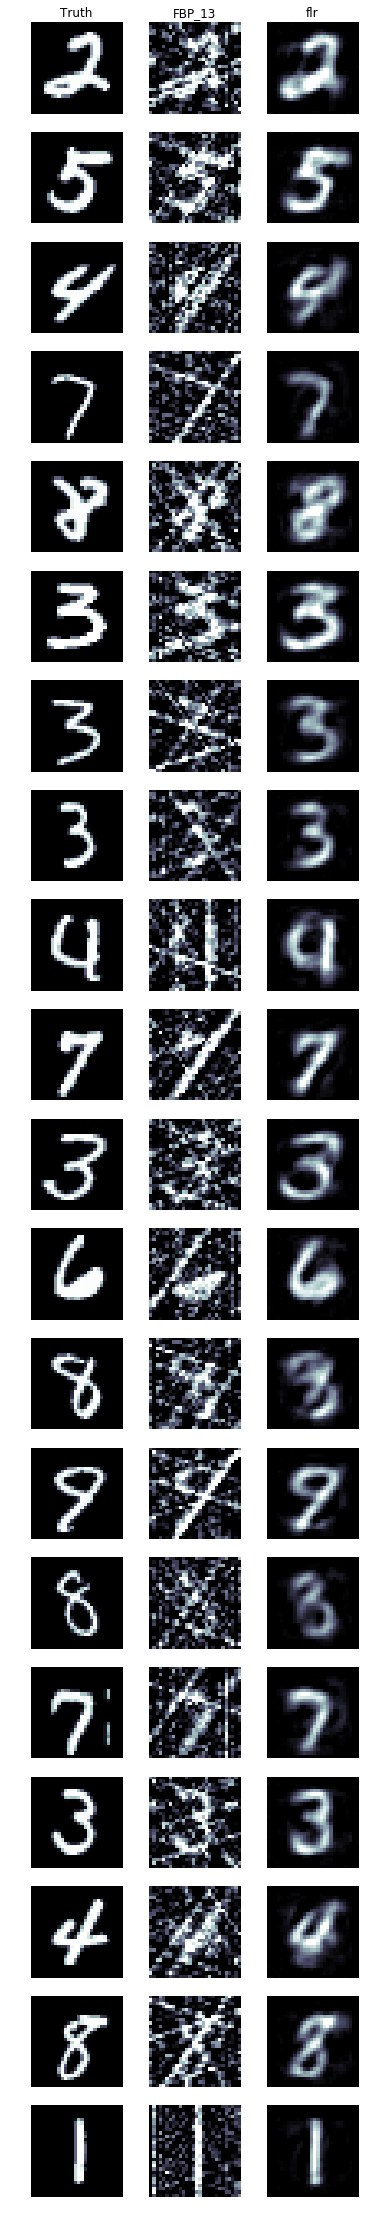

In [35]:
visualize([tf_fbp_op(y), x_result_fully], y)

# FBP + Learned denoiser

A more efficient method is to first compute some initial reconstruction (here, a filtered back-projection) and then learn how to improve that reconstruction. By doing this, we only need to learn in image space and can thus use very strong tools from machine learning, including convolutional neural networks.

In this example, we use a residual network of the form

$$
x_0 = \mathcal{T}^\dagger(y)
\\
x_{i+1} = \Lambda_{\theta_i}(x_i)
\\
\mathcal{T}_\theta^\dagger(y) = x_I
$$

In [15]:
with tf.variable_scope('denoise', reuse=tf.AUTO_REUSE):
    with tf.name_scope('learned_denoiser'):
        current = tf_fbp_op(y)

        for i in range(2):
            dx = tf.contrib.layers.conv2d(current, num_outputs=32, kernel_size=3)
            dx = tf.contrib.layers.conv2d(dx, num_outputs=32, kernel_size=3)
            dx = tf.contrib.layers.conv2d(dx, num_outputs=1, kernel_size=1,
                                          activation_fn=None)
            
            current = current + dx

        x_result_denoise = current

    with tf.name_scope('optimizer_denoiser'):
        loss = tf.reduce_mean((x_result_denoise - x_true) ** 2)
        optimizer = tf.train.AdamOptimizer(beta2=0.99).minimize(loss)  # different beta2 for faster convergence

# Initialize all denoising variables
session.run([v.initializer for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='denoise')]);

In [16]:
max_iter = 10000
for i in range(max_iter):
    batch = mnist.train.next_batch(5)
    images = batch[0].reshape([-1, 28, 28, 1])
    data = generate_data(images)

    session.run(optimizer, feed_dict={x_true: images, y: data})

    display_progress(i, max_iter, x_result_denoise, y)

'10000/10000 Error: 0.01640'

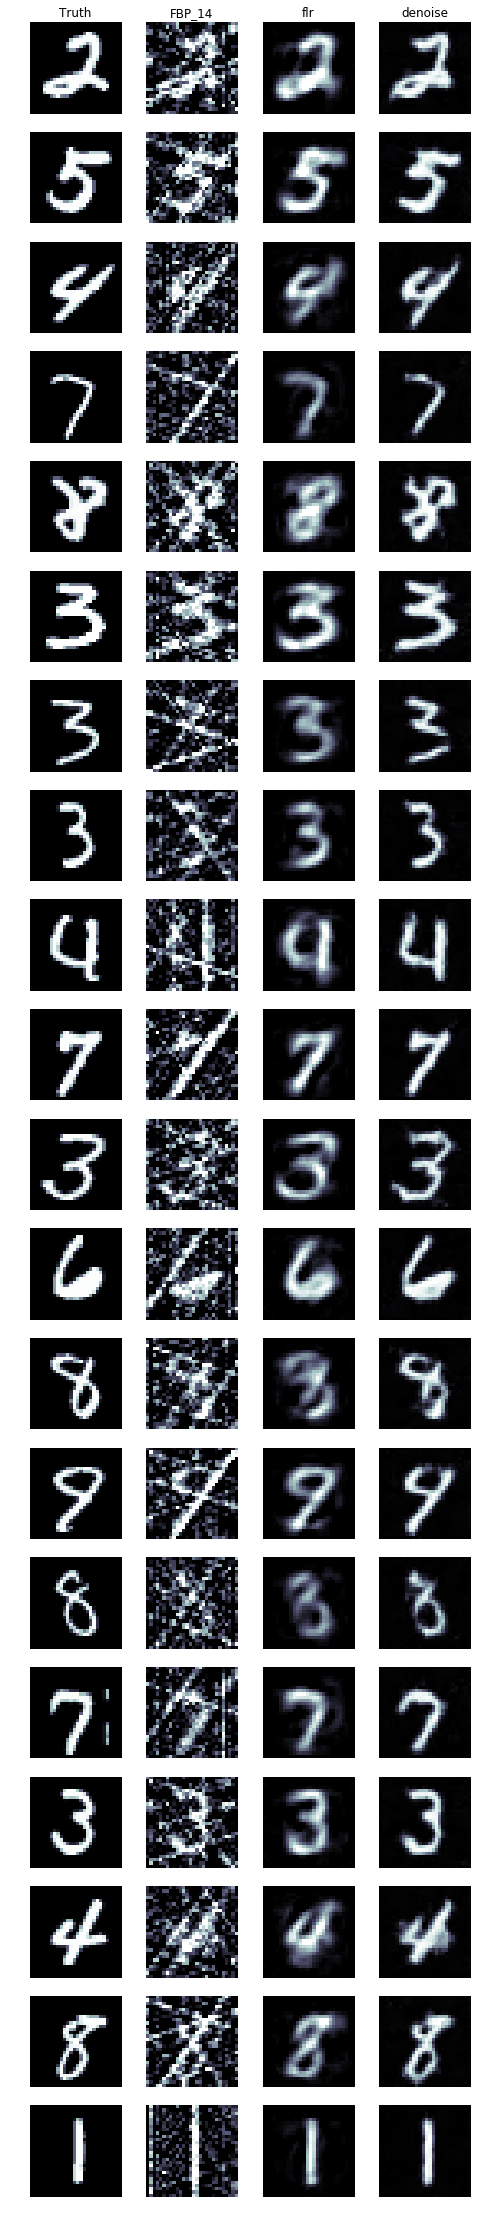

In [36]:
visualize([tf_fbp_op(y), x_result_fully, x_result_denoise], y)

# Learned Iterative reconstruction

In Learned iterative reconstruction, we embed the forward operator into a neural network and use it as a component in the neural network. By doing so, we never loose connection to the data during the reconstruction.

In this example, we use a so called (partially) Learned Gradient network of the form:

$$
x_0 = \mathcal{T}^\dagger(y)
\\
x_{i+1} = \Lambda_{\theta_i}(x_i, \mathcal{T}^*(\mathcal{T}(x_i) - y))
\\
\mathcal{T}_\theta^\dagger(y) = x_I
$$

Note that this is basically equivalent to the denoising network above, except we include the forward operator in each iteration.

In [18]:
with tf.variable_scope('learned_iterative', reuse=tf.AUTO_REUSE):
    with tf.name_scope('learned_iterative_reconstruction'):
        current = tf_fbp_op(y)

        for i in range(2):
            gradient = tf_op_adj(tf_op(current) - y)
            
            dx = tf.concat([current, gradient], axis=-1)
            dx = tf.contrib.layers.conv2d(dx, num_outputs=32, kernel_size=3)
            dx = tf.contrib.layers.conv2d(dx, num_outputs=32, kernel_size=3)
            dx = tf.contrib.layers.conv2d(dx, num_outputs=1, kernel_size=3,
                                          activation_fn=None)
            current = current + dx

        x_result_li = current

    with tf.name_scope('optimizer'):
        loss = tf.reduce_mean((x_result_lpd - x_true) ** 2)
        optimizer = tf.train.AdamOptimizer(beta2=0.99).minimize(loss)  # different beta2 for faster convergence

# Initialize all current variables
session.run([v.initializer for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='learned_iterative')]);

In [19]:
max_iter = 10000
for i in range(max_iter):
    batch = mnist.train.next_batch(5)
    images = batch[0].reshape([-1, 28, 28, 1])
    data = generate_data(images)

    session.run(optimizer, feed_dict={x_true: images, y: data})

    display_progress(i, max_iter, x_result_lpd, y)

'10000/10000 Error: 0.01065'

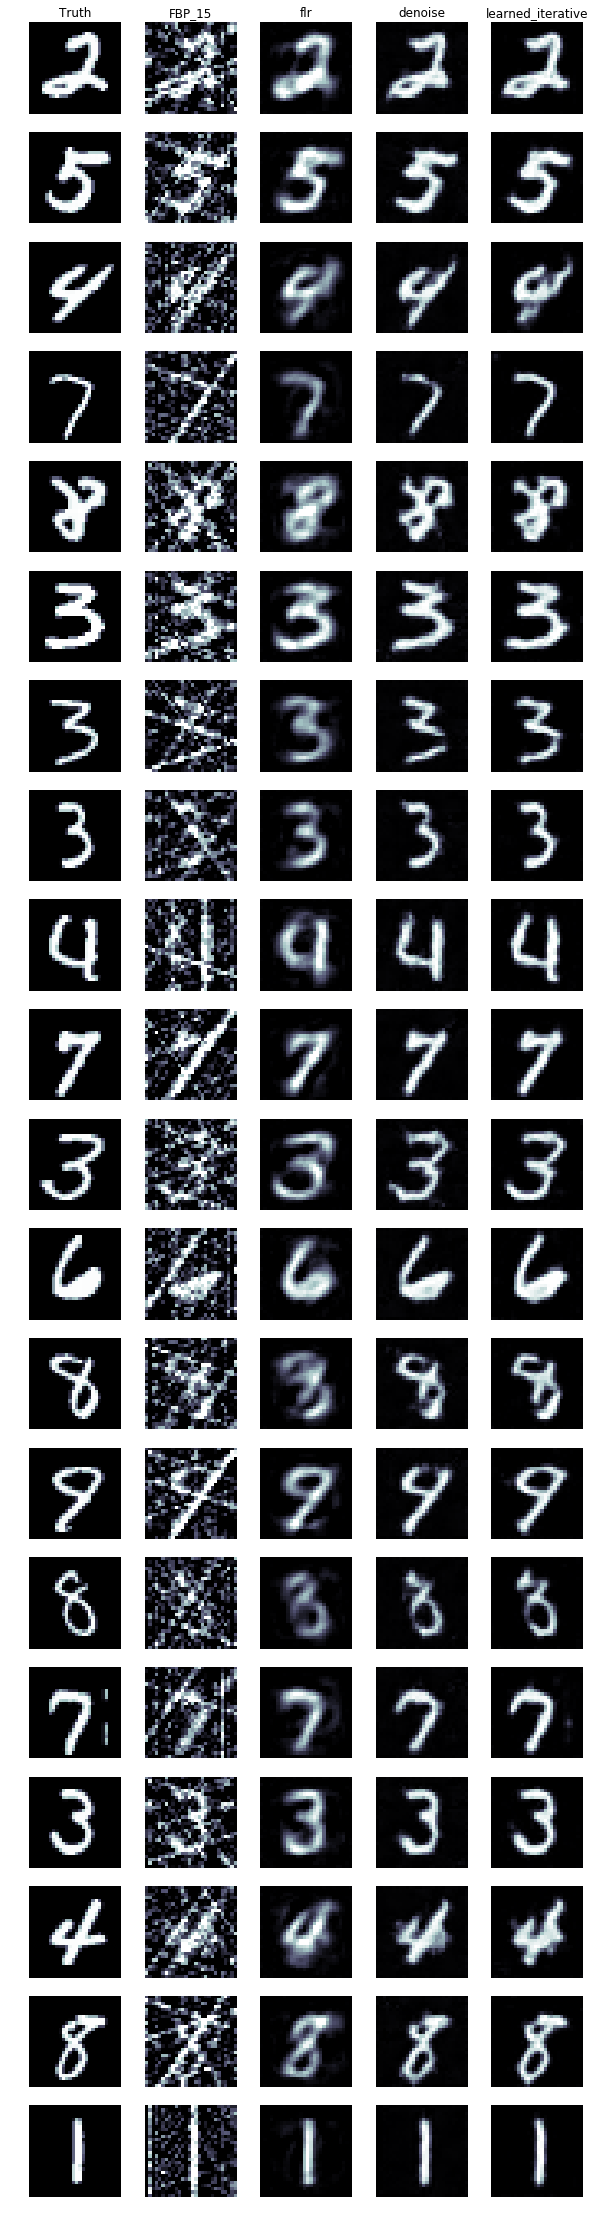

In [37]:
visualize([tf_fbp_op(y), x_result_fully, x_result_denoise, x_result_li], y)

# Total variation regularized reconstruction

As a comparison we also compute a TV regularized reconstruction closely following [part1_tv_denoising](part1_tv_denoising.ipynb) (see that notebook for details). Since the implementation is done in ODL, we convert the ODL reconstruction code into tensorflow code in order to be able to do the evaluation.

In [21]:
# Define the operators needed
grad = odl.Gradient(space)
L = odl.BroadcastOperator(operator, grad)

# Compute the step-size
L_norm = 1.1 * odl.power_method_opnorm(L)
tau = sigma = 1.0 / L_norm

def tv_recon(y):
    """Compute TV regularized reconstruction from data y
    
    Parameters
    ----------
    y : numpy.ndarray of shape (?, 5, 41, 1)
    
    Returns
    -------
    reconstruction : numpy.ndarray of shape (?, 28, 28, 1)
    """
    n = y.shape[0]
    results = np.zeros([n, 28, 28, 1], dtype='float32')
    
    for i in range(n):
        # Loop over all data in the batch, creating a new functional for each of them
        g = odl.solvers.IndicatorNonnegativity(space)
        f_1 = odl.solvers.L2NormSquared(operator.range).translated(y[i, ..., 0])
        f_2 = 1.0 * odl.solvers.L1Norm(grad.range)
        f = odl.solvers.SeparableSum(f_1, f_2)
        
        x = space.zero()
        odl.solvers.pdhg(x, f, g, L, tau=tau, sigma=sigma, gamma=0.3, niter=50)
        results[i, ..., 0] = x
        
    return results

In [25]:
# Convert to tensorflow layer
tf_tv_recon = tf.py_func(tv_recon, [y], tf.float32, name='tv_recon')

In [26]:
print('TV Mean squared error: {}'.format(evaluate(tf_tv_recon, y)))

TV Mean squared error: 0.02442108653485775


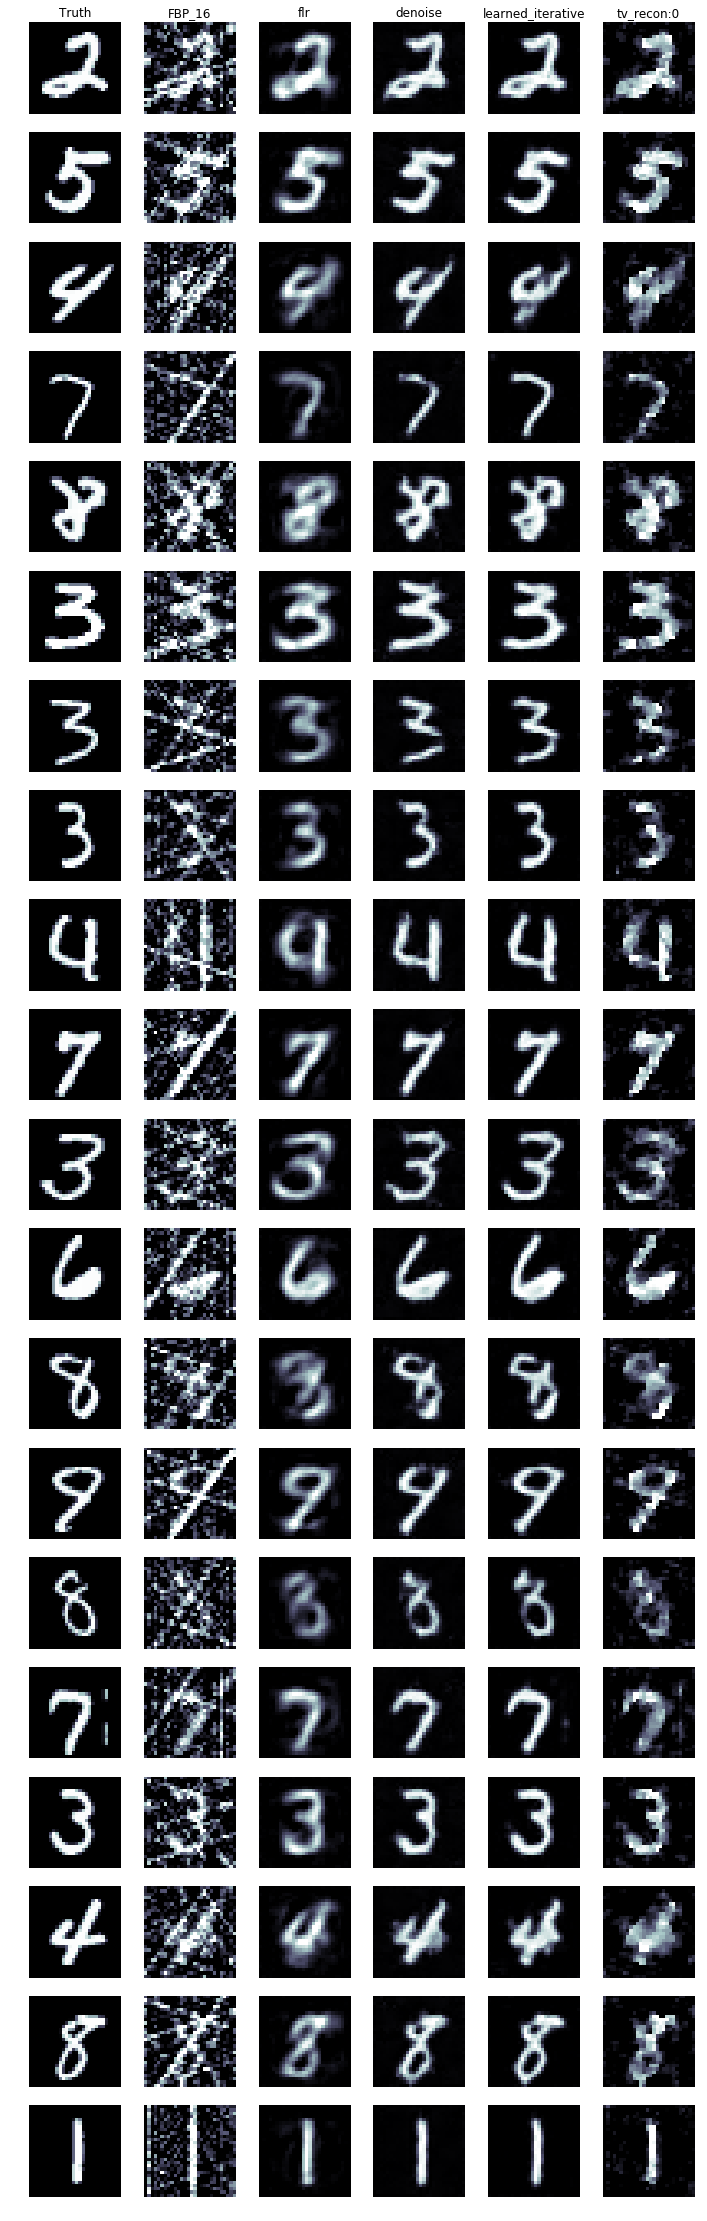

In [38]:
visualize([tf_fbp_op(y), x_result_fully, x_result_denoise, x_result_li, tf_tv_recon], y)